# SHAP analysis using PyTorch

In [1]:
#!/usr/bin/env python
# coding: utf-8
import os.path
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../python/')

from scipy.io import loadmat
import numpy as np
from numpy.random import seed

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette='muted')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import shap
shap.initjs()

from tqdm import tqdm

import torch
from torch import Tensor
import torchsummary
from torch.nn import MSELoss, L1Loss
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from plot_utils import *
from interpretability_utils import *
from regression_utils import cnn_prediction
from torch_utils import *
from architecture import IPA

SEED_VALUE = 1
seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
fontsize = 30
plt.rc('font', size=fontsize*.8) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize/1.5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize/1.5) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize/1.5) #fontsize of the legend

## Loading data & model

In [3]:
""" MODEL LOGISTICS """
MODEL_NAME = 'IPA'
path_model = '../model/'

""" BASE HPs """
batch_size = 16
epochs = 500
initial_lr = .00025

# """ REGULARIZATION HPs """
l2_lambda = .001

In [4]:
data_prefix = "../data"
data = loadmat(f"{data_prefix}/raw-kennard-reduced_range.mat")

X_train = data['X_train']
X_test = data['X_test']

y_train_scaled = np.genfromtxt(f'{data_prefix}/y_train_scaled.csv', delimiter=',')
y_test_scaled = np.genfromtxt(f'{data_prefix}/y_test_scaled.csv', delimiter=',')
y_train_scaled = y_train_scaled[..., np.newaxis]
y_test_scaled = y_test_scaled[..., np.newaxis]

W = data['W'][0]

In [5]:
outliers_spectra = X_test[[9,19], :]

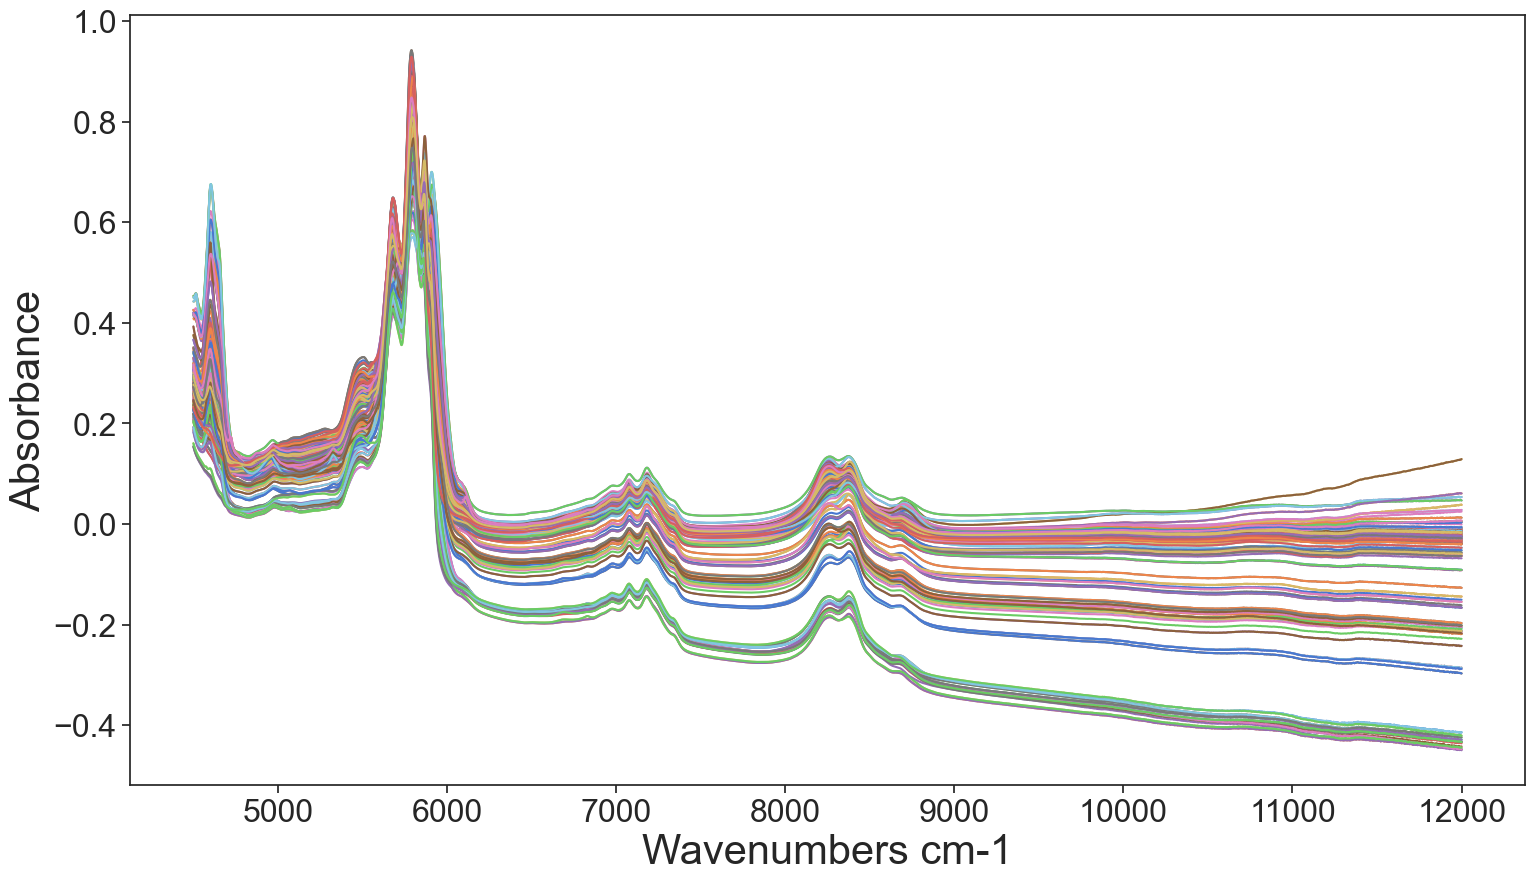

In [6]:
X = np.concatenate([X_train, X_test])
plot_df(X, W)

In [7]:
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train_reshaped = X_train.unsqueeze(1)
X_test_reshaped = X_test.unsqueeze(1)
# X_train_reshaped.shape, y_train.shape, X_test_reshaped.shape, y_test.shape

train_loader = create_dataloader(X_train_reshaped, y_train, batch_size)
test_loader = create_dataloader(X_test_reshaped, y_test, batch_size)

batch = next(iter(test_loader))
signals, _ = batch

In [8]:
if not os.path.exists(path_model + MODEL_NAME):
    # Initialize the model, loss function, and optimizer
    model = IPA().to(device)
    model = init_weights(model) # HeInitialization
    
    criterion_train = L1Loss()
    criterion_test = MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    decay_steps, decay_rate = 10000, 0.001 # Lr scheduler HPs
    lr_scheduler = ExponentialLR(optimizer, gamma=(1 - decay_rate) ** (1 / decay_steps))
    
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
        train_loss = train(model, device, train_loader, l2_lambda, criterion_train, optimizer)
        test_loss = test(model, device, test_loader, criterion_test)
    
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Performance analysis - Calibration
    y_preds = np.array(model(X_train_reshaped).detach().cpu())
    rmsec = mean_squared_error(y_train_scaled, y_preds, squared=False)
    print(f'RMSEC: {rmsec:.3f}')
    
    full_path = f'{path_model}{MODEL_NAME}'
    print(f'Saving model in {full_path}')
    if not os.path.exists(full_path):
        os.makedirs(path_model)
    torch.save(model.state_dict(), full_path)

else:
    print('Model does exist, performing regression.')
    model = IPA().to(device)
    model.load_state_dict(torch.load(f'{path_model}{MODEL_NAME}'))

    # Performance analysis - Calibration
    y_preds = np.array(model(X_train_reshaped).detach().cpu())
    rmsec = mean_squared_error(y_train_scaled, y_preds, squared=False)
    print(f'RMSEC: {rmsec:.3f}')

# Performance analysis - Validation
y_preds = np.array(model(X_test_reshaped).detach().cpu())
rmsep = mean_squared_error(y_test_scaled, y_preds, squared=False)
r2 = r2_score(y_test_scaled, y_preds)
print(f"RMSEP: {rmsep:.3f} - R2P: {r2:.3f}")
print(f'Fit ratio: {rmsec/rmsep:.3f}')

# torchsummary.summary(model, input_size=X_train_reshaped.shape[1:])

Epochs: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41epoch/s]

RMSEC: 0.114
Saving model in ../model/IPA
RMSEP: 0.104 - R2P: 0.991
Fit ratio: 1.097


## Full training set - Mean absolute SVs

In [9]:
input_sample = X_train.unsqueeze(1)[:]
print(input_sample.shape)

ex = shap.DeepExplainer(model, input_sample)
shapley_values_raw = ex.shap_values(input_sample)
shap_values = shapley_values_raw.squeeze(1)

torch.Size([174, 1, 3890])


In [10]:
def compute_moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

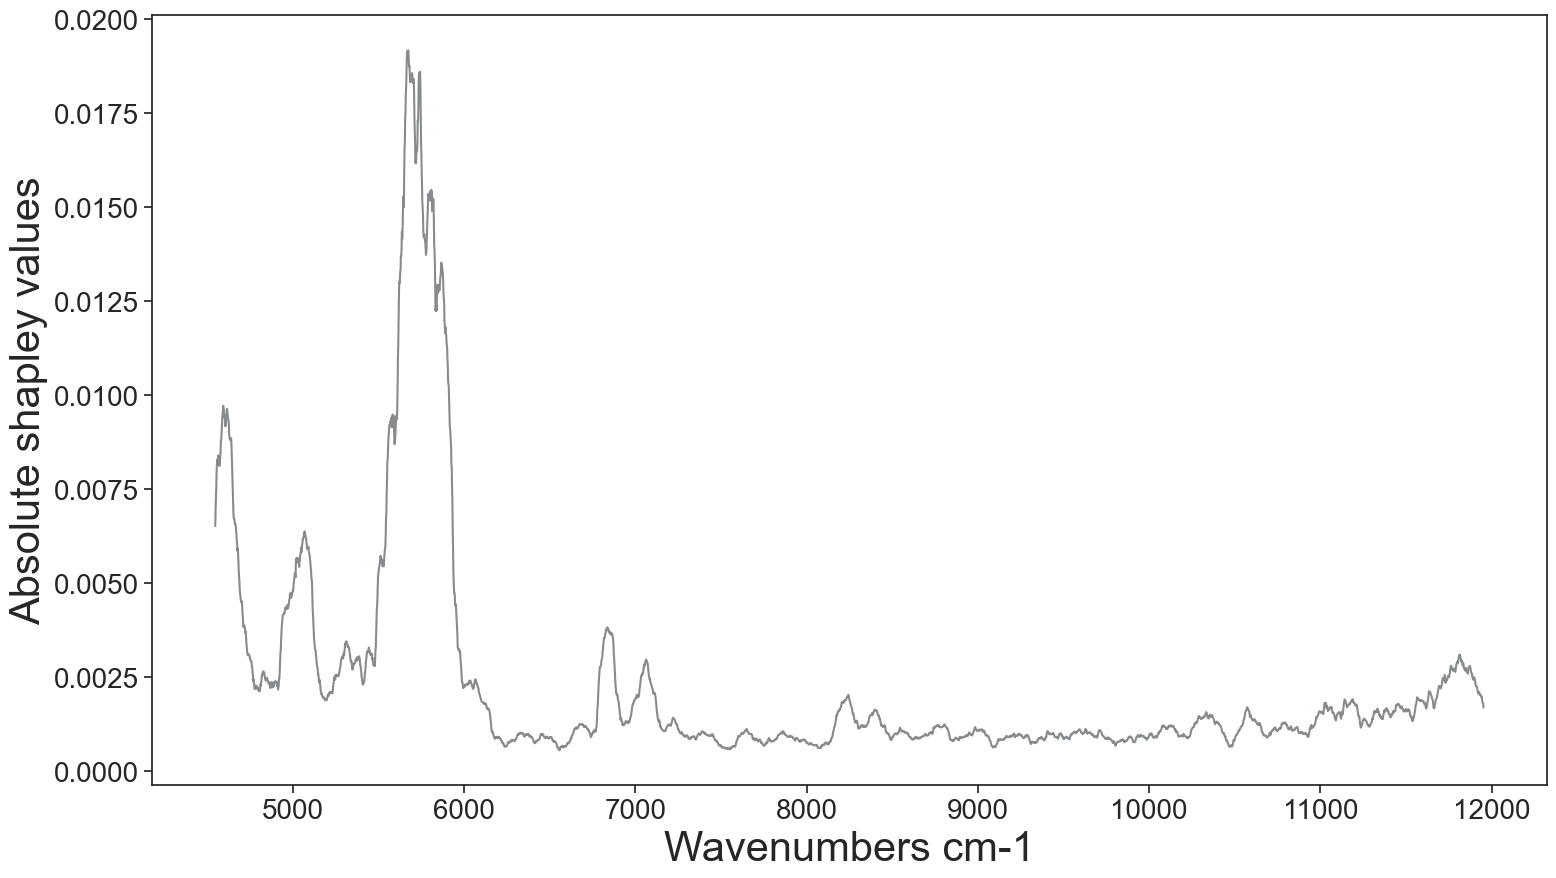

In [11]:
window = 50
mean_absolute_features = np.average(np.abs(shap_values), axis=0)
moving_average_features = compute_moving_average(mean_absolute_features, window)
moving_average_W = compute_moving_average(W, window)

df_ma = pd.DataFrame(moving_average_features).T
df_ma.columns = moving_average_W

lineplot_shapley(df_ma, palette=['#888B8D'])

## Outliers on validation set - Plot spectra & SVs

In [12]:
idx_to_analyze = [9,19]
input_sample = X_test.unsqueeze(1)[idx_to_analyze, :]
print(input_sample.shape)

ex = shap.DeepExplainer(model, input_sample)
outliers_shap_raw = ex.shap_values(input_sample)
outliers_shap = outliers_shap_raw.squeeze(1)

torch.Size([2, 1, 3890])


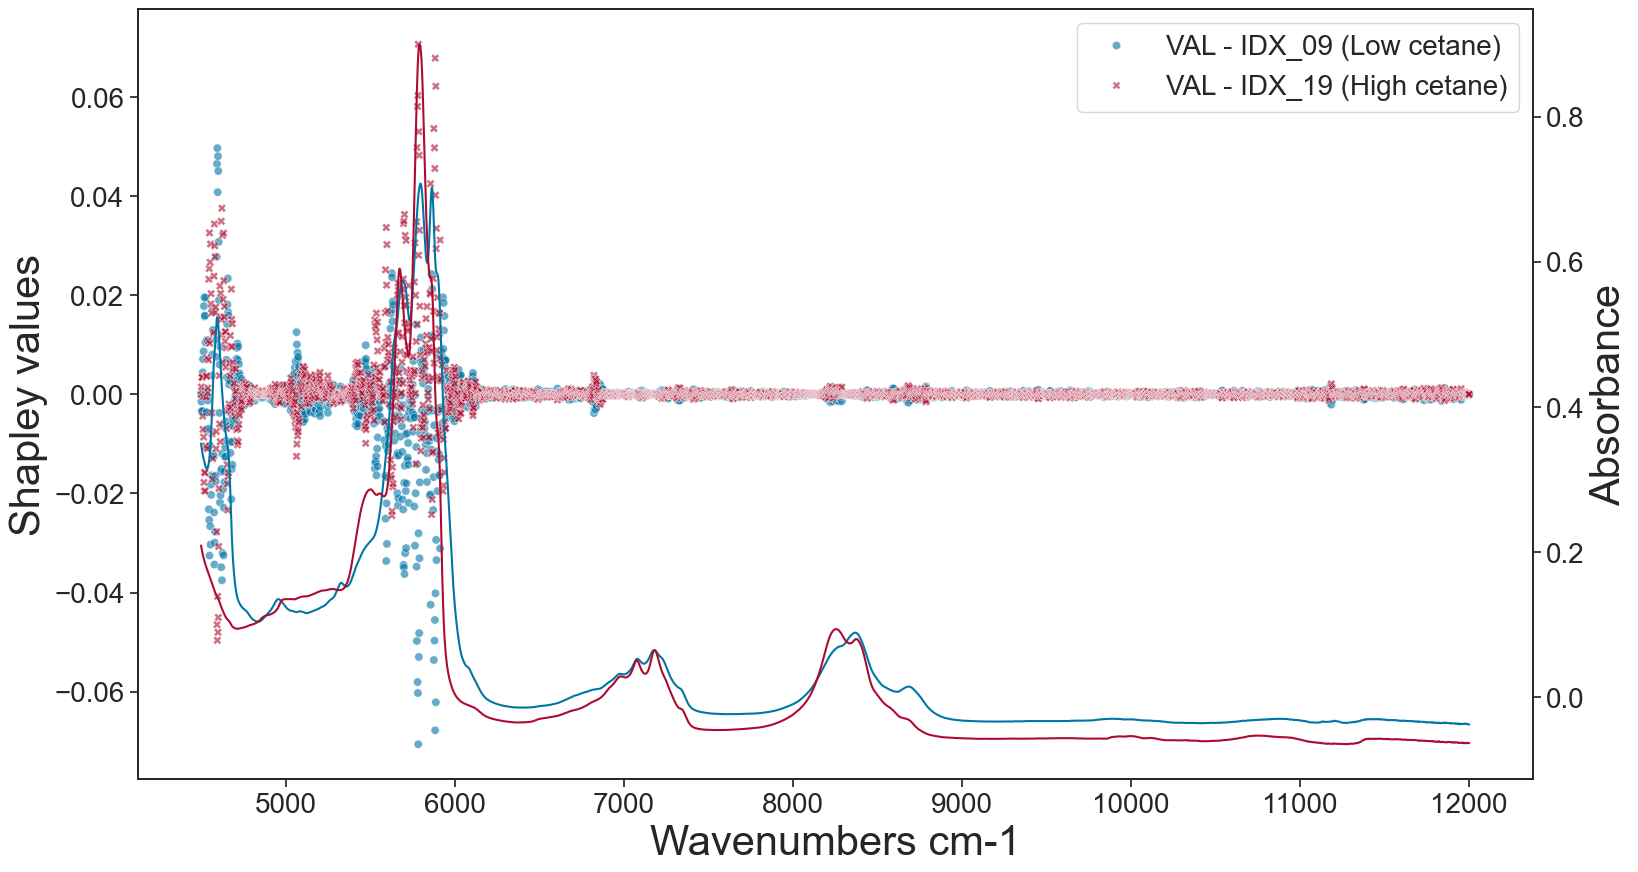

In [13]:
legend = ['VAL - IDX_09 (Low cetane)', 
          'VAL - IDX_19 (High cetane)']

df_outliers_shap = pd.DataFrame(outliers_shap)
df_outliers_shap.columns = W
df_outliers_shap.index = legend

df_outliers_spectra = pd.DataFrame(outliers_spectra)
df_outliers_spectra.columns = W
df_outliers_shap.index = legend

multiplot_shap_line(df_outliers_shap, df_outliers_spectra, palette=['#0076A5', '#AB0C2F'])